In [126]:
## pip install xlrd         //엑셀다루는 기본페키지
## !pip install -q sklearn   //train_test_split 사용할 페키지

In [170]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import os

from tensorflow import feature_column
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

## [첫번째 dataframe 받아와서 정제하기]

In [171]:
def load_income_data(income_path):
    csv_path = os.path.join(income_path,
                            "V10O1610293.csv")
    return pd.read_csv(csv_path)

In [172]:
dataframe1 = load_income_data(".")

In [173]:
dataframe1.info()
dataframe1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495360 entries, 0 to 495359
Data columns (total 11 columns):
tm             495360 non-null int64
serial         495360 non-null object
flag           495360 non-null int64
pm10           495360 non-null int64
co2            495360 non-null int64
vocs           495360 non-null int64
noise          495360 non-null int64
temp           495360 non-null float64
humi           495360 non-null int64
pm25           490990 non-null float64
Unnamed: 10    0 non-null float64
dtypes: float64(3), int64(7), object(1)
memory usage: 41.6+ MB


,tm,serial,flag,pm10,co2,vocs,noise,temp,humi,pm25,Unnamed: 10
0,201804010000,V10O1610293,1,67,-9999,-9999,48,15.0,51,40.0,NaN
1,201804010001,V10O1610293,1,61,-9999,-9999,48,15.0,51,37.0,NaN
2,201804010002,V10O1610293,1,56,-9999,-9999,48,14.9,51,34.0,NaN
3,201804010003,V10O1610293,1,67,-9999,-9999,48,14.9,51,40.0,NaN
4,201804010004,V10O1610293,1,59,-9999,-9999,48,14.9,51,35.0,NaN


In [174]:
#원하는 조건의 '행'만 가져오기 
#(오전6시에 측정한 값)
newdf1 = dataframe1[dataframe1['tm']%10000 == 600]
#(pm10이 -999인 값 제거)
newdf1 = newdf1[newdf1['pm10'] != -999]

#필요없는 '열' 버리기
newdf1.drop(['serial','flag','co2','vocs','noise','temp','humi','pm25','Unnamed: 10'],axis="columns", inplace=True)

In [175]:
# 'tm'열의 값 10000으로 나눈 몫으로 교체 
# (년월일시분 -> 년월일)
# (밑에서 데이터를 합치기 위해..)
newdf1['tm'] = newdf1['tm']//10000

In [176]:
newdf1.info()
newdf1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 360 to 494280
Data columns (total 2 columns):
tm      342 non-null int64
pm10    342 non-null int64
dtypes: int64(2)
memory usage: 8.0 KB


,tm,pm10
360,20180401,67
1800,20180402,67
3240,20180403,79
4680,20180404,1
6120,20180405,4


## [두번째 dataframe 받아와서 정제하기]

In [177]:
#하나의 엑셀파일내에 있는 여러시트중 하나의 시트를 불러온다.
xls = pd.ExcelFile('GS리테일_동별 매출지수용 기준값 확인_AMT_NEW.xlsx')
dataframe2 = pd.read_excel(xls, '종합테이블')

In [178]:
dataframe2.info()
dataframe2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
OPER_DT      13125 non-null int64
BOR_CD       13125 non-null int64
ADMD_CD      13125 non-null int64
AMT_IND      13125 non-null float64
LCLS_10_P    13125 non-null float64
LCLS_20_P    13125 non-null float64
LCLS_30_P    13125 non-null float64
LCLS_40_P    13093 non-null float64
LCLS_50_P    13123 non-null float64
LCLS_60_P    12075 non-null float64
LCLS_70_P    12886 non-null float64
LCLS_80_P    12543 non-null float64
dtypes: float64(9), int64(3)
memory usage: 1.2 MB


,OPER_DT,BOR_CD,ADMD_CD,AMT_IND,LCLS_10_P,LCLS_20_P,LCLS_30_P,LCLS_40_P,LCLS_50_P,LCLS_60_P,LCLS_70_P,LCLS_80_P
0,20180401,1111,11110515,0.736933,0.279018,0.299569,0.334816,0.015636,0.053782,0.000265,0.013092,0.003823
1,20180401,1111,11110530,1.258473,0.237403,0.257984,0.349826,0.045502,0.092581,0.004988,0.002467,0.009250
2,20180401,1111,11110540,0.674164,0.254081,0.246844,0.324434,0.065025,0.089691,NaN,0.013212,0.006712
3,20180401,1111,11110550,1.010874,0.416368,0.217715,0.282613,0.026738,0.036622,0.005893,0.012295,0.001756
4,20180401,1111,11110560,1.012942,0.311321,0.267387,0.262358,0.014736,0.135350,NaN,0.007270,0.001577


In [179]:
#주소가 종로구 상계10동인 곳만 받아온다.
newdf2 = dataframe2[dataframe2['ADMD_CD']==11350720]

#필요없는 '열'은 버린다.
newdf2.drop(['BOR_CD','LCLS_10_P','LCLS_20_P','LCLS_30_P','LCLS_40_P','LCLS_60_P','LCLS_70_P','LCLS_80_P'],axis="columns", inplace=True)

In [180]:
# '열' 이름 바꾸기 (OPER_DT -> tm)
# (밑에서 데이터를 합치기 위해..)
newdf2.rename(columns={'OPER_DT': 'tm'}, inplace=True)

In [181]:
newdf2.info()
newdf2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 35 to 13124
Data columns (total 4 columns):
tm           365 non-null int64
ADMD_CD      365 non-null int64
AMT_IND      365 non-null float64
LCLS_50_P    365 non-null float64
dtypes: float64(2), int64(2)
memory usage: 14.3 KB


,tm,ADMD_CD,AMT_IND,LCLS_50_P
35,20180401,11350720,0.753311,0.046199
71,20180402,11350720,0.793845,0.052453
107,20180403,11350720,0.729169,0.046356
143,20180404,11350720,0.771234,0.064546
179,20180405,11350720,0.718121,0.061702


## [정제된 첫번째,두번째 데이터 합치기]

In [182]:
finalDf = pd.merge(newdf1,newdf2)

In [183]:
finalDf.info()
finalDf.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 341
Data columns (total 5 columns):
tm           342 non-null int64
pm10         342 non-null int64
ADMD_CD      342 non-null int64
AMT_IND      342 non-null float64
LCLS_50_P    342 non-null float64
dtypes: float64(2), int64(3)
memory usage: 16.0 KB


,tm,pm10,ADMD_CD,AMT_IND,LCLS_50_P
0,20180401,67,11350720,0.753311,0.046199
1,20180402,67,11350720,0.793845,0.052453
2,20180403,79,11350720,0.729169,0.046356
3,20180404,1,11350720,0.771234,0.064546
4,20180405,4,11350720,0.718121,0.061702


In [184]:
finalDf.describe()

,tm,pm10,ADMD_CD,AMT_IND,LCLS_50_P
count,3.420000e+02,342.000000,342.0,342.000000,342.000000
mean,2.018328e+07,56.850877,11350720.0,0.828902,0.050070
std,4.155737e+03,53.548657,0.0,0.117195,0.018609
min,2.018040e+07,1.000000,11350720.0,0.617784,0.013879
25%,2.018063e+07,27.000000,11350720.0,0.735518,0.039319
50%,2.018101e+07,43.000000,11350720.0,0.817306,0.045782
75%,2.019010e+07,64.750000,11350720.0,0.903725,0.056589
max,2.019033e+07,469.000000,11350720.0,1.303067,0.149348


In [185]:
# 총매출(AMT_IND)의 평균, 헬스뷰티매출(LCLS_50_P)의 평균
meanAMT = finalDf['AMT_IND'].mean()
meanLCLS = finalDf['LCLS_50_P'].mean()

In [186]:
# 평균보다 높으면 1, 낮으면 0
finalDf['AMT_IND'] = np.where(finalDf['AMT_IND'] > meanAMT, 1, 0)
finalDf['LCLS_50_P'] = np.where(finalDf['LCLS_50_P'] > meanLCLS, 1, 0)

In [187]:
finalDf.info()
finalDf.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 341
Data columns (total 5 columns):
tm           342 non-null int64
pm10         342 non-null int64
ADMD_CD      342 non-null int64
AMT_IND      342 non-null int64
LCLS_50_P    342 non-null int64
dtypes: int64(5)
memory usage: 16.0 KB


,tm,pm10,ADMD_CD,AMT_IND,LCLS_50_P
0,20180401,67,11350720,0,0
1,20180402,67,11350720,0,1
2,20180403,79,11350720,0,0
3,20180404,1,11350720,0,1
4,20180405,4,11350720,0,1


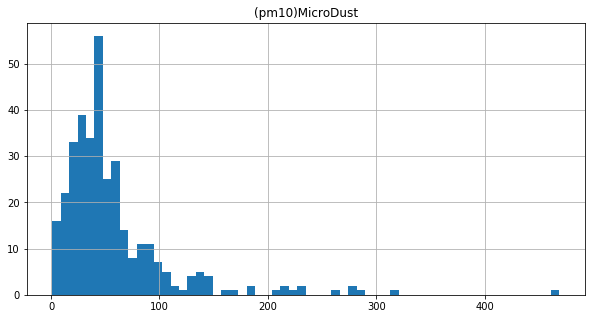

In [188]:
%matplotlib inline
import matplotlib.pyplot as plt

finalDf["pm10"].hist(bins=60, figsize=(10,5))
plt.title("(pm10)MicroDust")
plt.show()

In [189]:
#새로운 csv파일 만들기
#(필요한 자료만 모아 정제된 csv파일)
finalDf.to_csv("finalCsv.csv")

## [Train & Test]

In [190]:
train, test = train_test_split(finalDf, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), '훈련 샘플')
print(len(val), '검증 샘플')
print(len(test), '테스트 샘플')

218 훈련 샘플
55 검증 샘플
69 테스트 샘플


In [191]:
# 판다스 데이터프레임으로부터 tf.data 데이터셋을 만들기 위한 함수
def df_to_dataset(finalDf, shuffle=True, batch_size=32):
  finalDf = finalDf.copy()
  labels = finalDf.pop('AMT_IND')
  ds = tf.data.Dataset.from_tensor_slices((dict(finalDf), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(finalDf))
  ds = ds.batch(batch_size)
  return ds

In [192]:
batch_size = 5 # 예제를 위해 작은 배치 크기를 사용합니다.
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [193]:
for feature_batch, label_batch in train_ds.take(1):
  print('전체 특성:', list(feature_batch.keys()))
  print('pm10 특성의 배치:', feature_batch['pm10'])
  print('타깃의 배치:', label_batch )

전체 특성: ['tm', 'pm10', 'ADMD_CD', 'LCLS_50_P']
pm10 특성의 배치: tf.Tensor([17 27 22 42 82], shape=(5,), dtype=int32)
타깃의 배치: tf.Tensor([1 0 1 1 0], shape=(5,), dtype=int32)


In [201]:
feature_columns = []
for header in ['pm10']:
  feature_columns.append(feature_column.numeric_column(header))

In [202]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [203]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [204]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=20)

Epoch 1/20
7/7 [==============================] - 1s 110ms/step - loss: 1.7967 - accuracy: 0.5275 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
7/7 [==============================] - 0s 9ms/step - loss: 1.0335 - accuracy: 0.4725 - val_loss: 0.6836 - val_accuracy: 0.5273
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.9438 - accuracy: 0.5413 - val_loss: 0.8777 - val_accuracy: 0.4727
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.9474 - accuracy: 0.5183 - val_loss: 0.7697 - val_accuracy: 0.5273
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.8336 - accuracy: 0.5183 - val_loss: 0.9290 - val_accuracy: 0.4727
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.8919 - accuracy: 0.5505 - val_loss: 0.6869 - val_accuracy: 0.5273
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.7886 - accuracy: 0.5229 - val_loss: 0.6694 - val_accuracy: 0.5273
Epoch 8/20
7/7 [========

In [205]:
loss, accuracy = model.evaluate(test_ds)
print("정확도", accuracy)

3/3 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5362
정확도 0.5362319
